

# Project: Investigate a Dataset - TMDb Movies Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 


>The dataset contains the collection of 10800 movies with different properties such as original title of movie, imbd id, budget and revenue of movies, cast, directors, runtime, populaity, vote count, year of release and release date.


### Question(s) for Analysis

> Do movies with higher revenue generated receive high vote count and popularity

> How does the runtime of movies varies with individual preferences i.e do people prefer movies with shorter runtime or longer runtime 


In [60]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


In [61]:
#load movie data and inspect first few lines of the data
df_tmdb = pd.read_csv('tmdb-movies.csv')
df_tmdb.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


### Inspecting data type, instances of missing values, number of columns and rows

In [62]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [63]:
df_tmdb.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [64]:
df_tmdb.columns

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')


## Data Cleaning

 

### Dropping columns with higher missing values and those not relevant in the analysis process

In [65]:

df_tmdb.drop(['id', 'imdb_id','cast', 'homepage','tagline', 'keywords', 'overview','production_companies','release_date'],axis=1, inplace=True)

In [66]:
#Inspect data after the drop
df_tmdb.head(3)

,popularity,budget,revenue,original_title,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,150000000,1513528810,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,150000000,378436354,Mad Max: Fury Road,George Miller,120,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,110000000,295238201,Insurgent,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2480,6.3,2015,1.012000e+08,2.716190e+08


### checking for missing values, duplicates. Drop rows with missing values and duplicates

In [67]:
df_tmdb.isnull().sum()

popularity         0
budget             0
revenue            0
original_title     0
director          44
runtime            0
genres            23
vote_count         0
vote_average       0
release_year       0
budget_adj         0
revenue_adj        0
dtype: int64

In [68]:
df_tmdb.dropna(inplace=True)

### Inspecting number of rows and columns 

In [69]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10801 entries, 0 to 10865
Data columns (total 12 columns):
popularity        10801 non-null float64
budget            10801 non-null int64
revenue           10801 non-null int64
original_title    10801 non-null object
director          10801 non-null object
runtime           10801 non-null int64
genres            10801 non-null object
vote_count        10801 non-null int64
vote_average      10801 non-null float64
release_year      10801 non-null int64
budget_adj        10801 non-null float64
revenue_adj       10801 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 1.1+ MB


### Checking for duplicates. Then drop duplicates

In [70]:
df_tmdb[df_tmdb.duplicated()]

,popularity,budget,revenue,original_title,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
2090,0.59643,30000000,967000,TEKKEN,Dwight H. Little,92,Crime|Drama|Action|Thriller|Science Fiction,110,5.0,2010,30000000.0,967000.0


In [71]:
df_tmdb[df_tmdb['original_title'] == 'TEKKEN']

,popularity,budget,revenue,original_title,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
2089,0.59643,30000000,967000,TEKKEN,Dwight H. Little,92,Crime|Drama|Action|Thriller|Science Fiction,110,5.0,2010,30000000.0,967000.0
2090,0.59643,30000000,967000,TEKKEN,Dwight H. Little,92,Crime|Drama|Action|Thriller|Science Fiction,110,5.0,2010,30000000.0,967000.0


In [72]:
df_tmdb.drop_duplicates(inplace=True)

### Inspect the shape of data, data types and checking for any missing values

In [73]:
df_tmdb.shape

(10800, 12)

In [74]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10800 entries, 0 to 10865
Data columns (total 12 columns):
popularity        10800 non-null float64
budget            10800 non-null int64
revenue           10800 non-null int64
original_title    10800 non-null object
director          10800 non-null object
runtime           10800 non-null int64
genres            10800 non-null object
vote_count        10800 non-null int64
vote_average      10800 non-null float64
release_year      10800 non-null int64
budget_adj        10800 non-null float64
revenue_adj       10800 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 1.1+ MB


### Checking for the number of unique values in the data set

In [75]:
df_tmdb.nunique()

popularity        10750
budget              556
revenue            4702
original_title    10507
director           5056
runtime             245
genres             2031
vote_count         1289
vote_average         71
release_year         56
budget_adj         2610
revenue_adj        4839
dtype: int64

### Inspecting the values of budget column

In [76]:
df_tmdb['budget'].head()

0    150000000
1    150000000
2    110000000
3    200000000
4    190000000
Name: budget, dtype: int64

### Inspecting the dataset where budget and revenue equal 0

In [77]:
df_tmdb.query('budget == 0').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5636 entries, 30 to 10864
Data columns (total 12 columns):
popularity        5636 non-null float64
budget            5636 non-null int64
revenue           5636 non-null int64
original_title    5636 non-null object
director          5636 non-null object
runtime           5636 non-null int64
genres            5636 non-null object
vote_count        5636 non-null int64
vote_average      5636 non-null float64
release_year      5636 non-null int64
budget_adj        5636 non-null float64
revenue_adj       5636 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 572.4+ KB


In [78]:
df_tmdb.query('revenue == 0').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 48 to 10865
Data columns (total 12 columns):
popularity        5952 non-null float64
budget            5952 non-null int64
revenue           5952 non-null int64
original_title    5952 non-null object
director          5952 non-null object
runtime           5952 non-null int64
genres            5952 non-null object
vote_count        5952 non-null int64
vote_average      5952 non-null float64
release_year      5952 non-null int64
budget_adj        5952 non-null float64
revenue_adj       5952 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 604.5+ KB


### Inspecting rows where budget and revenue values equal zero

In [79]:
zero_bud = df_tmdb[df_tmdb['budget'] == 0]

In [80]:
zero_bud_rev = zero_bud.query('revenue == 0')

In [81]:
zero_bud_rev.head(3)

,popularity,budget,revenue,original_title,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
74,2.165433,0,0,Mythica: The Darkspore,Anne K. Black,108,Action|Adventure|Fantasy,27,5.1,2015,0.0,0.0
75,2.141506,0,0,Me and Earl and the Dying Girl,Alfonso Gomez-Rejon,105,Comedy|Drama,569,7.7,2015,0.0,0.0
92,1.876037,0,0,Mythica: The Necromancer,A. Todd Smith,0,Fantasy|Action|Adventure,11,5.4,2015,0.0,0.0


### Creating a checkpoint for data cleaning

In [82]:
df_tmdb_1 = df_tmdb.copy() 

### Drop rows where budget and revenue values equal 0

In [83]:
df_tmdb_1.drop(zero_bud_rev.index, axis= 0, inplace= True)

### Inspect dataset new info

In [84]:
df_tmdb_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159 entries, 0 to 10865
Data columns (total 12 columns):
popularity        6159 non-null float64
budget            6159 non-null int64
revenue           6159 non-null int64
original_title    6159 non-null object
director          6159 non-null object
runtime           6159 non-null int64
genres            6159 non-null object
vote_count        6159 non-null int64
vote_average      6159 non-null float64
release_year      6159 non-null int64
budget_adj        6159 non-null float64
revenue_adj       6159 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 625.5+ KB


### Masking budget and revenue  value to contain values greater than 1000000. Assuming the minimum budget and revenue of movies is about 1,000,000 dollars for easy analysis of data

In [85]:
mask_bud = df_tmdb_1.query('budget >= 1000000')

In [86]:
mask_rev = mask_bud.query('revenue >= 1000000')

### Checking the number of rows and columns of dataset

In [87]:
mask_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3521 entries, 0 to 10848
Data columns (total 12 columns):
popularity        3521 non-null float64
budget            3521 non-null int64
revenue           3521 non-null int64
original_title    3521 non-null object
director          3521 non-null object
runtime           3521 non-null int64
genres            3521 non-null object
vote_count        3521 non-null int64
vote_average      3521 non-null float64
release_year      3521 non-null int64
budget_adj        3521 non-null float64
revenue_adj       3521 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 357.6+ KB


### Creating a new check point for my cleaned data

In [88]:
new_tmdb = mask_rev.copy()

### Checking the number of unique values in the dataset and its descriptive statistics

In [89]:
new_tmdb.nunique()

popularity        3520
budget             317
revenue           3447
original_title    3483
director          1521
runtime            133
genres            1004
vote_count        1272
vote_average        52
release_year        56
budget_adj        1900
revenue_adj       3516
dtype: int64

In [90]:
new_tmdb.describe()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,3521.000000,3.521000e+03,3.521000e+03,3521.000000,3521.000000,3521.000000,3521.000000,3.521000e+03,3.521000e+03
mean,1.258651,4.016079e+07,1.173538e+08,110.059642,568.171258,6.185231,2001.150525,4.776175e+07,1.488367e+08
std,1.522592,4.288236e+07,1.816226e+08,19.608001,909.174669,0.785658,11.232439,4.517488e+07,2.219004e+08
min,0.010335,1.000000e+06,1.000000e+06,26.000000,10.000000,3.300000,1960.000000,9.199996e+05,9.403612e+05
25%,0.499298,1.200000e+07,1.899972e+07,96.000000,83.000000,5.700000,1995.000000,1.634191e+07,2.563668e+07
50%,0.874938,2.500000e+07,5.347817e+07,106.000000,234.000000,6.200000,2004.000000,3.320834e+07,7.166496e+07
75%,1.460430,5.200000e+07,1.372985e+08,120.000000,628.000000,6.700000,2010.000000,6.458261e+07,1.767132e+08
max,32.985763,4.250000e+08,2.781506e+09,248.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


## Research Question 1: Do movies with higher revenue generated receive high vote count and popularity?

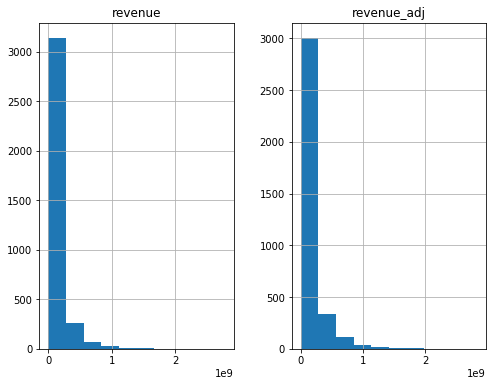

In [91]:
#Exploring with histograms, the revenue and revenue_adj
new_tmdb[['revenue_adj', 'revenue']].hist(figsize= (8,6));

### Creating a scatter plot to check how popularity varies with revenue created

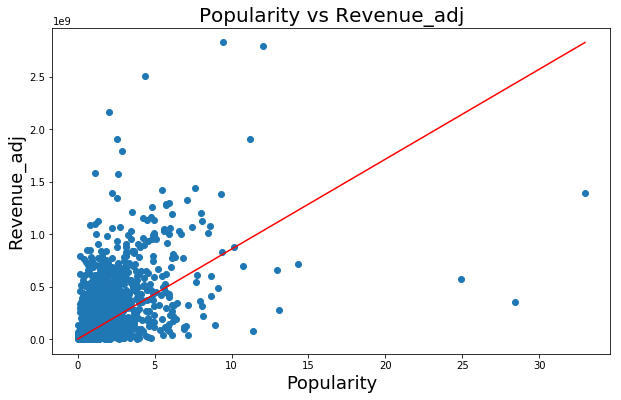

In [92]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(x =  new_tmdb['popularity'], y = new_tmdb['revenue_adj'])
ax.plot((0, new_tmdb['popularity'].max()), (0, new_tmdb['revenue_adj'].max()), color = 'red')
ax.set_title('Popularity vs Revenue_adj', fontsize= 20)
ax.set_xlabel('Popularity', fontsize = 18)
ax.set_ylabel('Revenue_adj', fontsize = 18)
plt.show();

### Creating a scatter plot to check how vote_count varies with revenue created

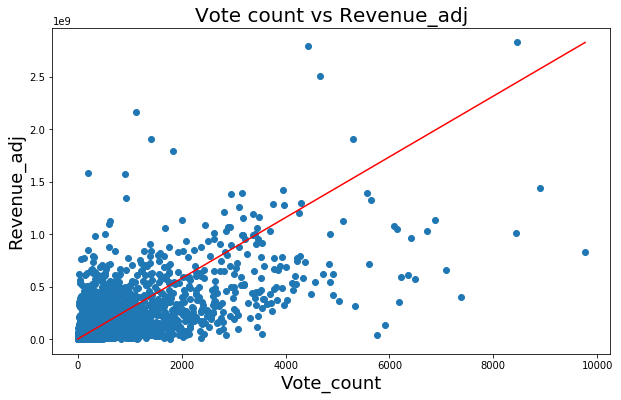

In [93]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(x =  new_tmdb['vote_count'], y = new_tmdb['revenue_adj'])
ax.plot((0, new_tmdb['vote_count'].max()), (0, new_tmdb['revenue_adj'].max()), color = 'red')
ax.set_title('Vote count vs Revenue_adj', fontsize= 20)
ax.set_xlabel('Vote_count', fontsize = 18)
ax.set_ylabel('Revenue_adj', fontsize = 18)
plt.show();

### From both scatter plot, it can be inferred that; movies the generated high revenue, also received high vote and are popular. Using bar chart to show the correlation between vote count and revenue generated as well as that for popularity and revenue generated

In [97]:
#defines a function to show the relationship between feature columns
def Correlation_bar(feature_1, feature_2):
    plt.title(feature_1.name + ' correlation vs ' + feature_2.name, fontsize = 15)
    plt.xlabel('Correlation', fontsize = 12)
    
    return sns.barplot(feature_1.corr(feature_2))

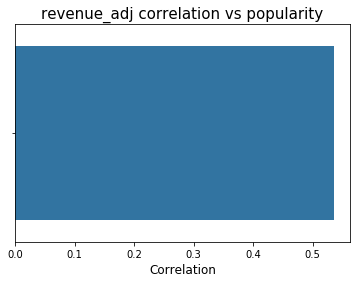

In [98]:
Correlation_bar(new_tmdb['revenue_adj'],new_tmdb['popularity']);

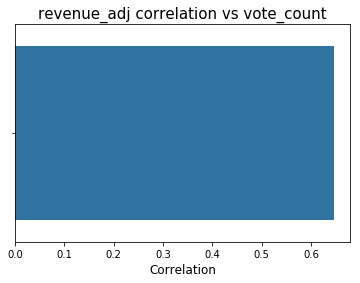

In [96]:
Correlation_bar(new_tmdb['revenue_adj'],new_tmdb['vote_count']);

### grouping by the mean vote count received  for revenue and popularity

In [62]:
rev_vot_pop = new_tmdb.groupby('vote_count')['revenue_adj','popularity'].mean()

In [63]:
rev_vot_pop['revenue_adj'].max()

2827123750.41189

### Comparing the max revenue from mean vote count. it can be seen that Avatar has high vote count its popularity is far greater than the avaerage of 1.26.

In [33]:
new_tmdb['popularity'].mean()

1.2586514518602667

In [32]:
new_tmdb.query('revenue_adj == 2827123750.41189')

,popularity,budget,revenue,original_title,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
1386,9.432768,237000000,2781505847,Avatar,James Cameron,162,Action|Adventure|Fantasy|Science Fiction,8458,7.1,2009,2.408869e+08,2.827124e+09


## Research Question 2:  How does the runtime of movies varies with individual preferences i.e do people prefer movies with shorter runtime or longer runtime

### Creating a scatter plot to explore the relationship between runtime and popularity

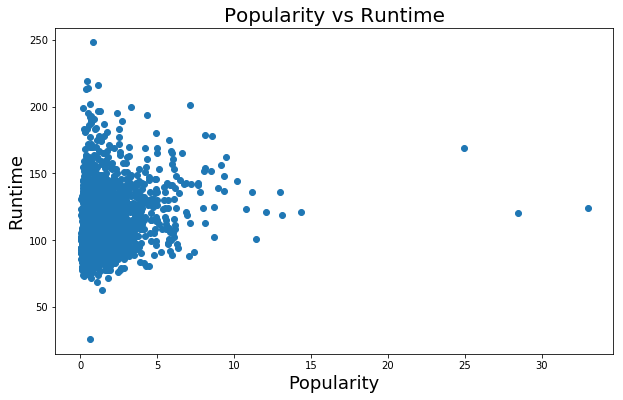

In [70]:

fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(x =  new_tmdb['popularity'], y = new_tmdb['runtime'])
ax.set_title('Popularity vs Runtime', fontsize= 20)
ax.set_xlabel('Popularity', fontsize = 18)
ax.set_ylabel('Runtime', fontsize = 18)
plt.show();

### Creating a scatter plot to explore the relationship between runtime and vote_count

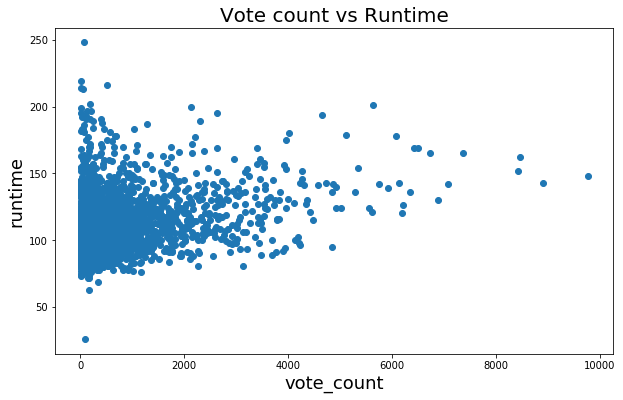

In [71]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(x =  new_tmdb['vote_count'], y = new_tmdb['runtime'])
ax.set_title('Vote count vs Runtime', fontsize= 20)
ax.set_xlabel('vote_count', fontsize = 18)
ax.set_ylabel('runtime', fontsize = 18)
plt.show();

In [72]:
new_tmdb['runtime'].nunique()

133

###  Group runtime by popularity and vote count

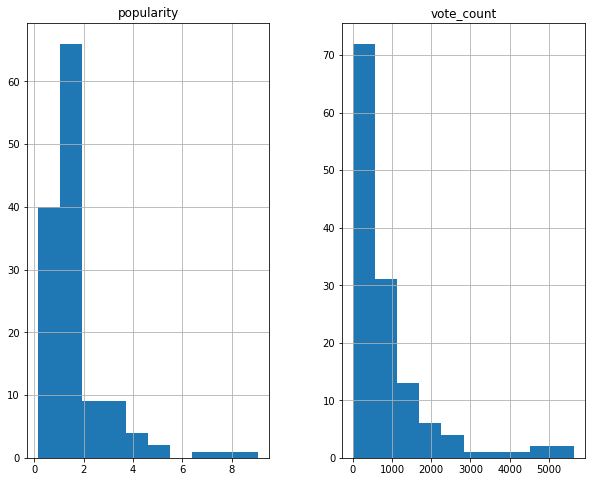

In [40]:
new_tmdb.groupby('runtime')['popularity', 'vote_count'].mean().hist(figsize=(10,8));

### Create a correlation between runtime, popularity and vote_count 

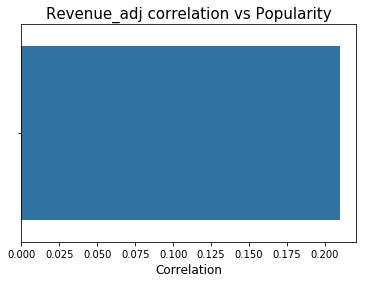

In [86]:
sns.barplot(new_tmdb['runtime'].corr(new_tmdb['popularity']))
plt.title('Revenue_adj correlation vs Popularity', fontsize = 15)
plt.xlabel('Correlation', fontsize = 12);

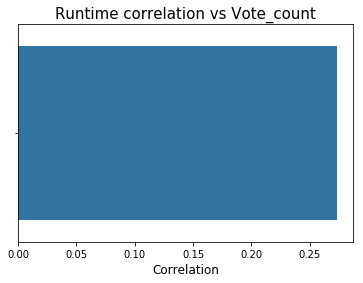

In [88]:
sns.barplot(new_tmdb['runtime'].corr(new_tmdb['vote_count']))
plt.title('Runtime correlation vs Vote_count', fontsize = 15)
plt.xlabel('Correlation', fontsize = 12);

### It cannot be concluded that there is a relationship between runtime, popularity and vote count.

<a id='conclusions'></a>
## Conclusions


> Based on statistical trend, the movies that generated high revenue also received high vote count and their popularity is above the average

> The movies runtime does not necessary affect its popularity amongst individuals and the way they voted. Longer runtime or shorter runtime cannot be inferred to have an effect on the popularity of the movies.

> More than half of the data has budget and revenue value of zero, making it challenging to draw adequate conclusion for the small size anakysed.

> It was also assumed the minimum budget and revenue to be 1,000,000 in order to remove outliers values. This assumption is based on personal preference.

## Submitting your Project 


In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0